<a href="https://colab.research.google.com/github/rglopesdf/airline-network-shortest-paths/blob/main/notebooks/Codeshare_Gol_Azul_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Codeshare Gol + Azul com Algoritmo de Johnson

## Objetivo
Implementar um grafo combinado da malha aérea da Gol e Azul simulando codeshare total, e usar o algoritmo de Johnson para identificar oportunidades reais de codeshare onde o menor caminho envolve ambas as companhias.

## Metodologia
1. **Coleta de dados**: Malhas aéreas da Gol e Azul com coordenadas geográficas
2. **Construção do grafo**: Rede combinada com 153 aeroportos e 450 rotas
3. **Algoritmo de Johnson**: Cálculo de caminhos mínimos entre todos os pares
4. **Análise de codeshare**: Identificação de rotas que utilizam ambas as companhias

## Resultados Principais
- **400 oportunidades de codeshare** identificadas
- **90.5% rotas internacionais**, demonstrando complementaridade das malhas
- **GRU como principal hub** de conexão (206 conexões)
- **Rota mais eficiente**: PDP ↔ AEP (1.499 km, 1 escala)

## 1. Importação de Bibliotecas e Configuração

In [21]:
# 1. Clonar o repositório
!git clone https://github.com/rglopesdf/airline-network-shortest-paths.git

# 2. Navegar para o diretório
import os
os.chdir('airline-network-shortest-paths' )

# 3. Instalar dependências
!pip install -r requirements.txt

# 4. Verificar estrutura do projeto
!ls -la

# 5. Listar notebooks disponíveis
!ls notebooks/

print("✅ Projeto clonado e configurado com sucesso!")
print("📁 Diretório atual:", os.getcwd())


Cloning into 'airline-network-shortest-paths'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 51 (delta 5), reused 45 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 7.40 MiB | 23.69 MiB/s, done.
Resolving deltas: 100% (5/5), done.
total 72
drwxr-xr-x  9 root root  4096 Jun 18 02:37 .
drwxr-xr-x 10 root root  4096 Jun 18 02:37 ..
-rw-r--r--  1 root root  2172 Jun 18 02:37 CONTRIBUTING.md
drwxr-xr-x  5 root root  4096 Jun 18 02:37 data
drwxr-xr-x  2 root root  4096 Jun 18 02:37 docs
drwxr-xr-x  2 root root  4096 Jun 18 02:37 examples
drwxr-xr-x  8 root root  4096 Jun 18 02:37 .git
drwxr-xr-x  2 root root  4096 Jun 18 02:37 images
-rw-r--r--  1 root root  1066 Jun 18 02:37 LICENSE
drwxr-xr-x  2 root root  4096 Jun 18 02:37 notebooks
-rw-r--r--  1 root root 13041 Jun 18 02:37 README.md
-rw-r--r--  1 root root  6484 Jun 18 02:37 REPOSITORY_STRUCTURE.md
-rw-r--r--  1 roo

In [22]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import json
import warnings
warnings.filterwarnings('ignore')

# Configurar matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Bibliotecas importadas com sucesso")

✓ Bibliotecas importadas com sucesso


## 2. Funções Auxiliares

In [23]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos na Terra usando a fórmula de Haversine
    Retorna a distância em quilômetros
    """
    # Converter graus para radianos
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Fórmula de Haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Raio da Terra em quilômetros
    return c * r

def algoritmo_johnson_combinado(G):
    """
    Implementação do algoritmo de Johnson adaptada para a malha aérea combinada
    Baseada no código original do usuário
    """
    # Criar cópia do grafo e adicionar vértice auxiliar
    G_aux = G.copy()
    G_aux.add_node('q')
    for node in G.nodes():
        G_aux.add_edge('q', node, weight=0)

    try:
        # Executar Bellman-Ford a partir do vértice auxiliar
        h = nx.single_source_bellman_ford_path_length(G_aux, 'q', weight='weight')
    except nx.NetworkXUnbounded:
        raise Exception("O grafo possui ciclo negativo!")

    # Reponderar as arestas
    G_reponderado = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        w = data['weight']
        w_prime = w + h[u] - h[v]
        G_reponderado.add_edge(u, v, weight=w_prime)

    # Executar Dijkstra a partir de cada vértice
    dist = dict()
    paths = dict()
    for node in G_reponderado.nodes():
        d, p = nx.single_source_dijkstra(G_reponderado, node, weight='weight')
        dist[node] = d
        paths[node] = p

    # Corrigir as distâncias para o grafo original
    for u in dist:
        for v in dist[u]:
            dist[u][v] = dist[u][v] + h[v] - h[u]

    return dist, paths

print("✓ Funções auxiliares definidas")

✓ Funções auxiliares definidas


## 3. Carregamento e Análise dos Dados

In [24]:
# Carregar dados das companhias
print("Carregando dados das malhas aéreas...")

# Dados da Gol
gol_airports = pd.read_csv('data/processed/gol_airports_coordinates.csv')
gol_codes = set(gol_airports['code'])

# Dados da Azul
azul_airports = pd.read_csv('data/processed/azul_airports_coordinates.csv')
azul_codes = set(azul_airports['code'])

# Dados combinados
combined_airports = pd.read_csv('data/processed/combined_airports_coordinates.csv')
both_codes = gol_codes.intersection(azul_codes)

print(f"Gol: {len(gol_codes)} aeroportos")
print(f"Azul: {len(azul_codes)} aeroportos")
print(f"Em comum: {len(both_codes)} aeroportos")
print(f"Total único: {len(combined_airports)} aeroportos")

# Estatísticas básicas
comparison_stats = pd.DataFrame({
    'Métrica': ['Aeroportos Gol', 'Aeroportos Azul', 'Em Comum', 'Total Único'],
    'Valor': [len(gol_codes), len(azul_codes), len(both_codes), len(combined_airports)]
})

display(comparison_stats)

Carregando dados das malhas aéreas...
Gol: 76 aeroportos
Azul: 140 aeroportos
Em comum: 63 aeroportos
Total único: 153 aeroportos


Métrica  Valor
0   Aeroportos Gol     76
1  Aeroportos Azul    140
2         Em Comum     63
3      Total Único    153

🗺️ Mapa da Rede Combinada:


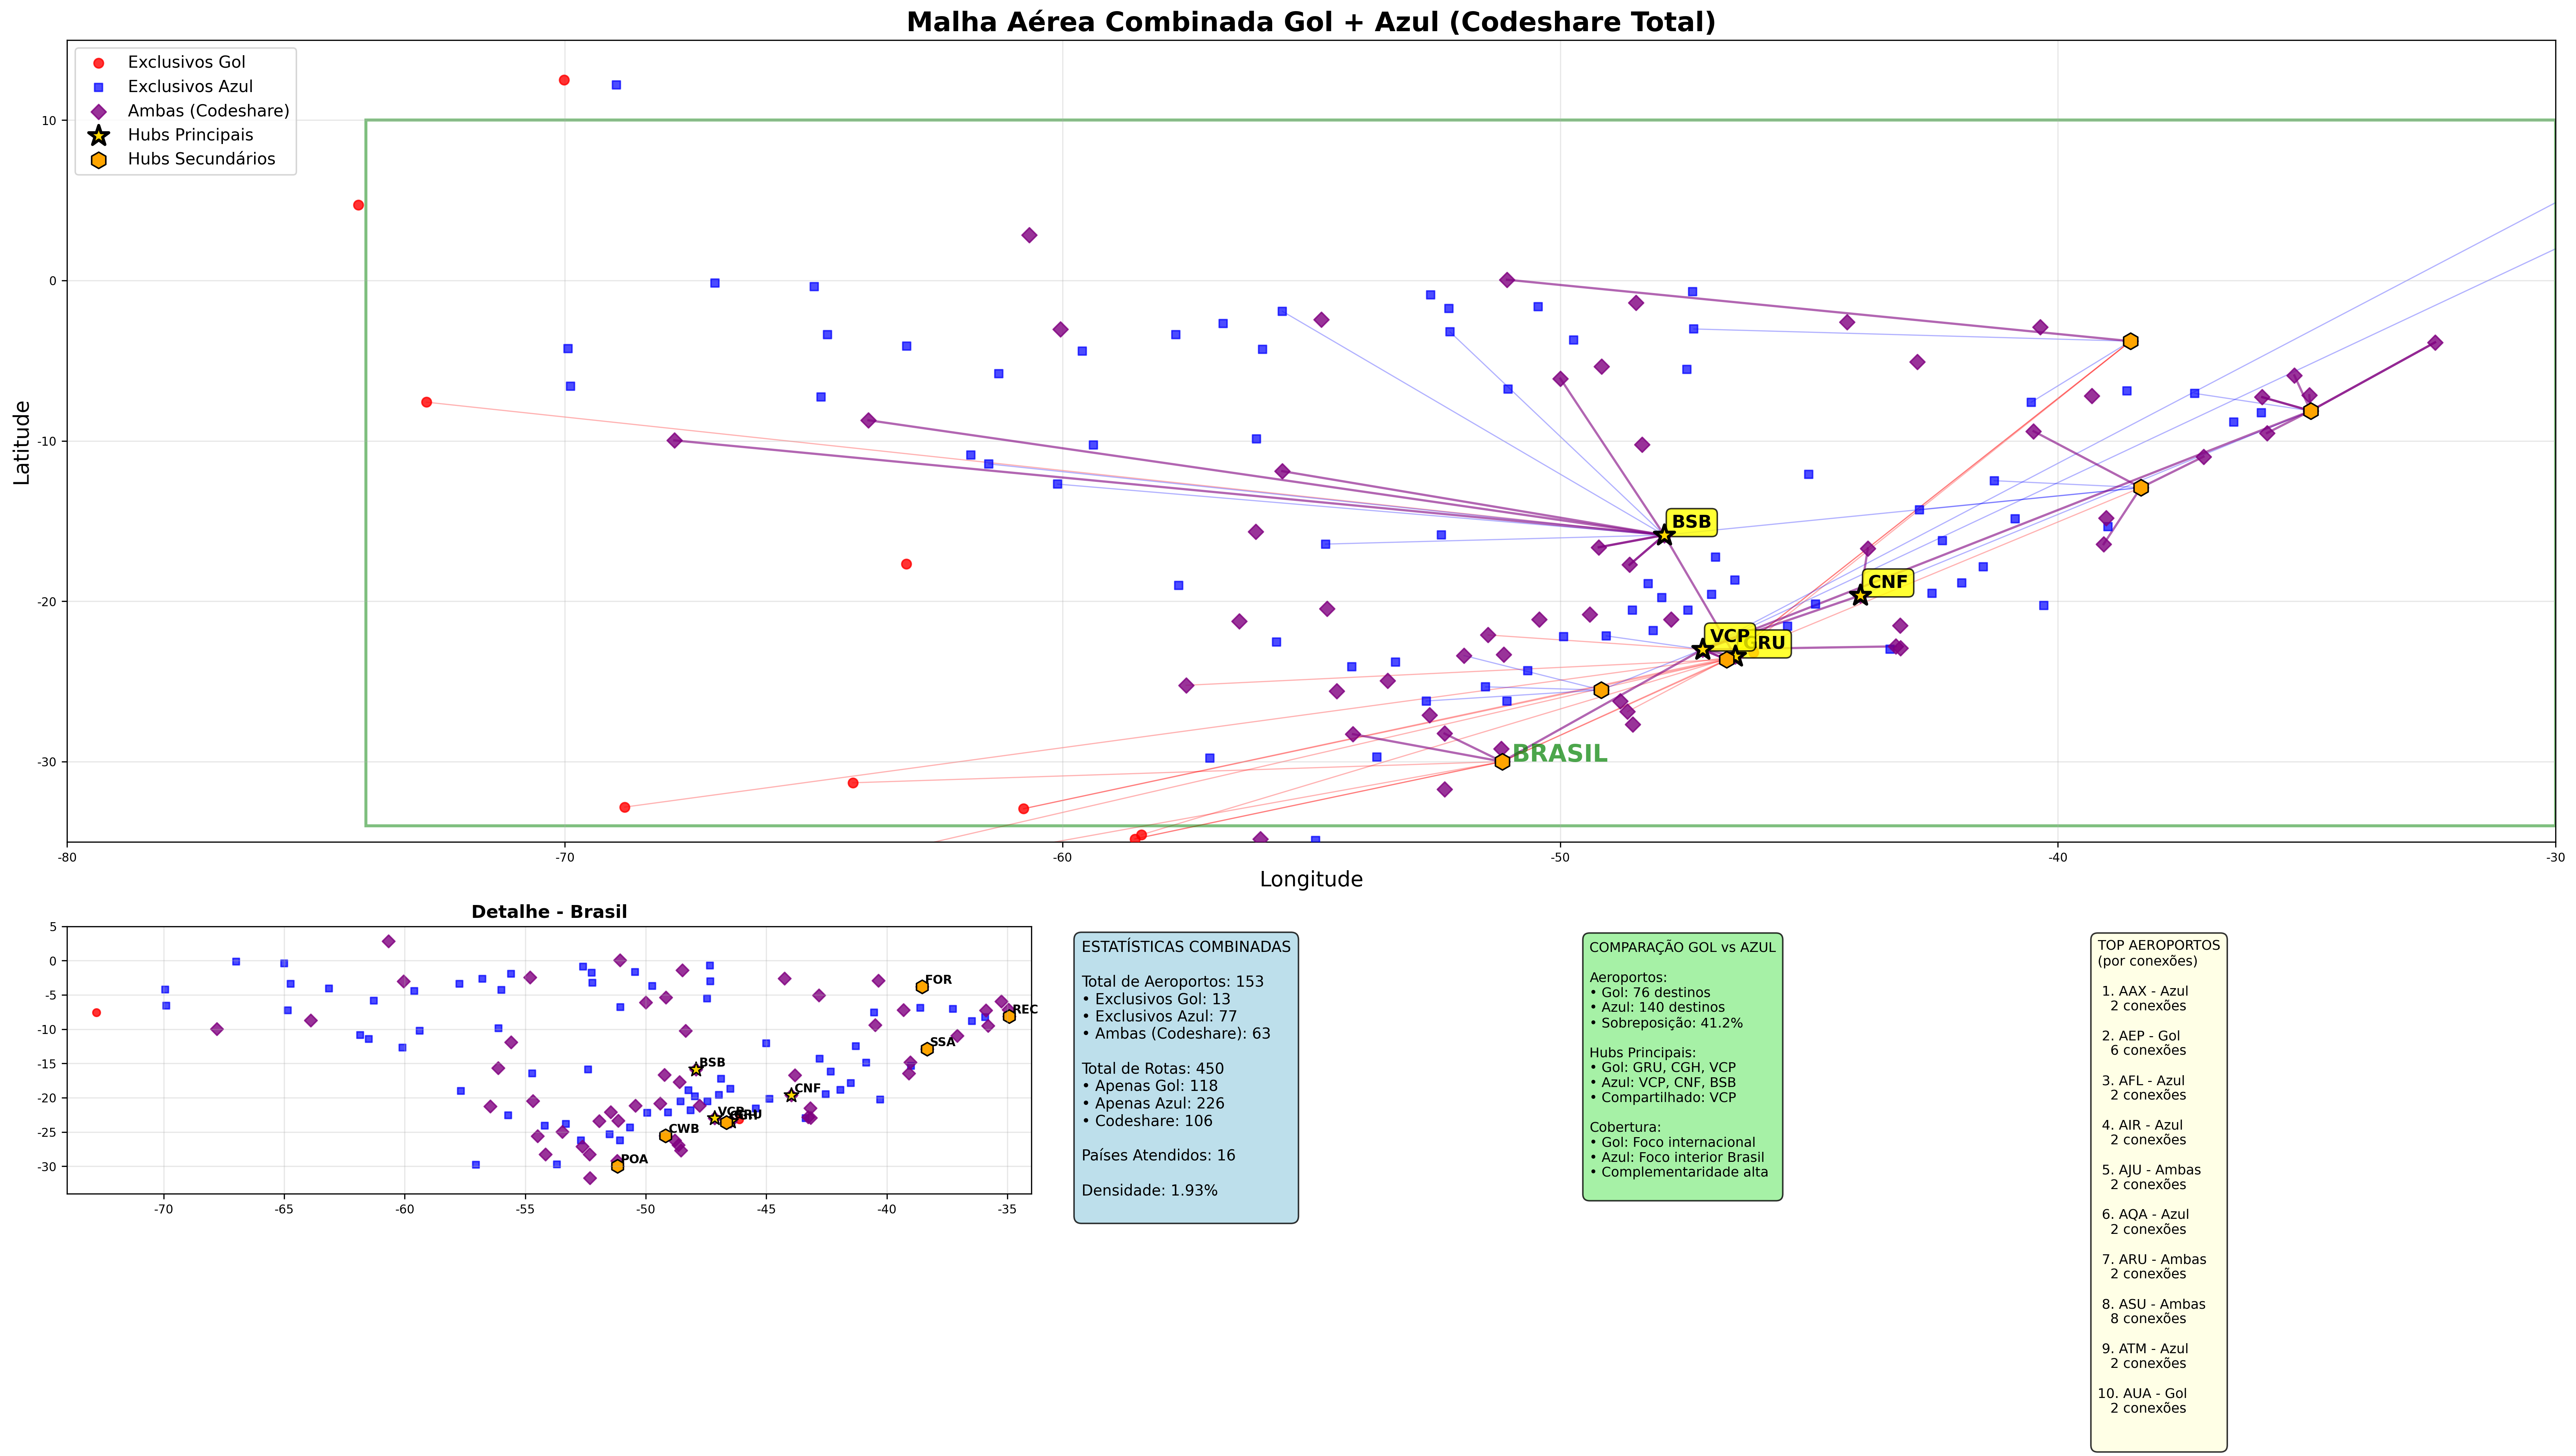


📊 Análise de Oportunidades:


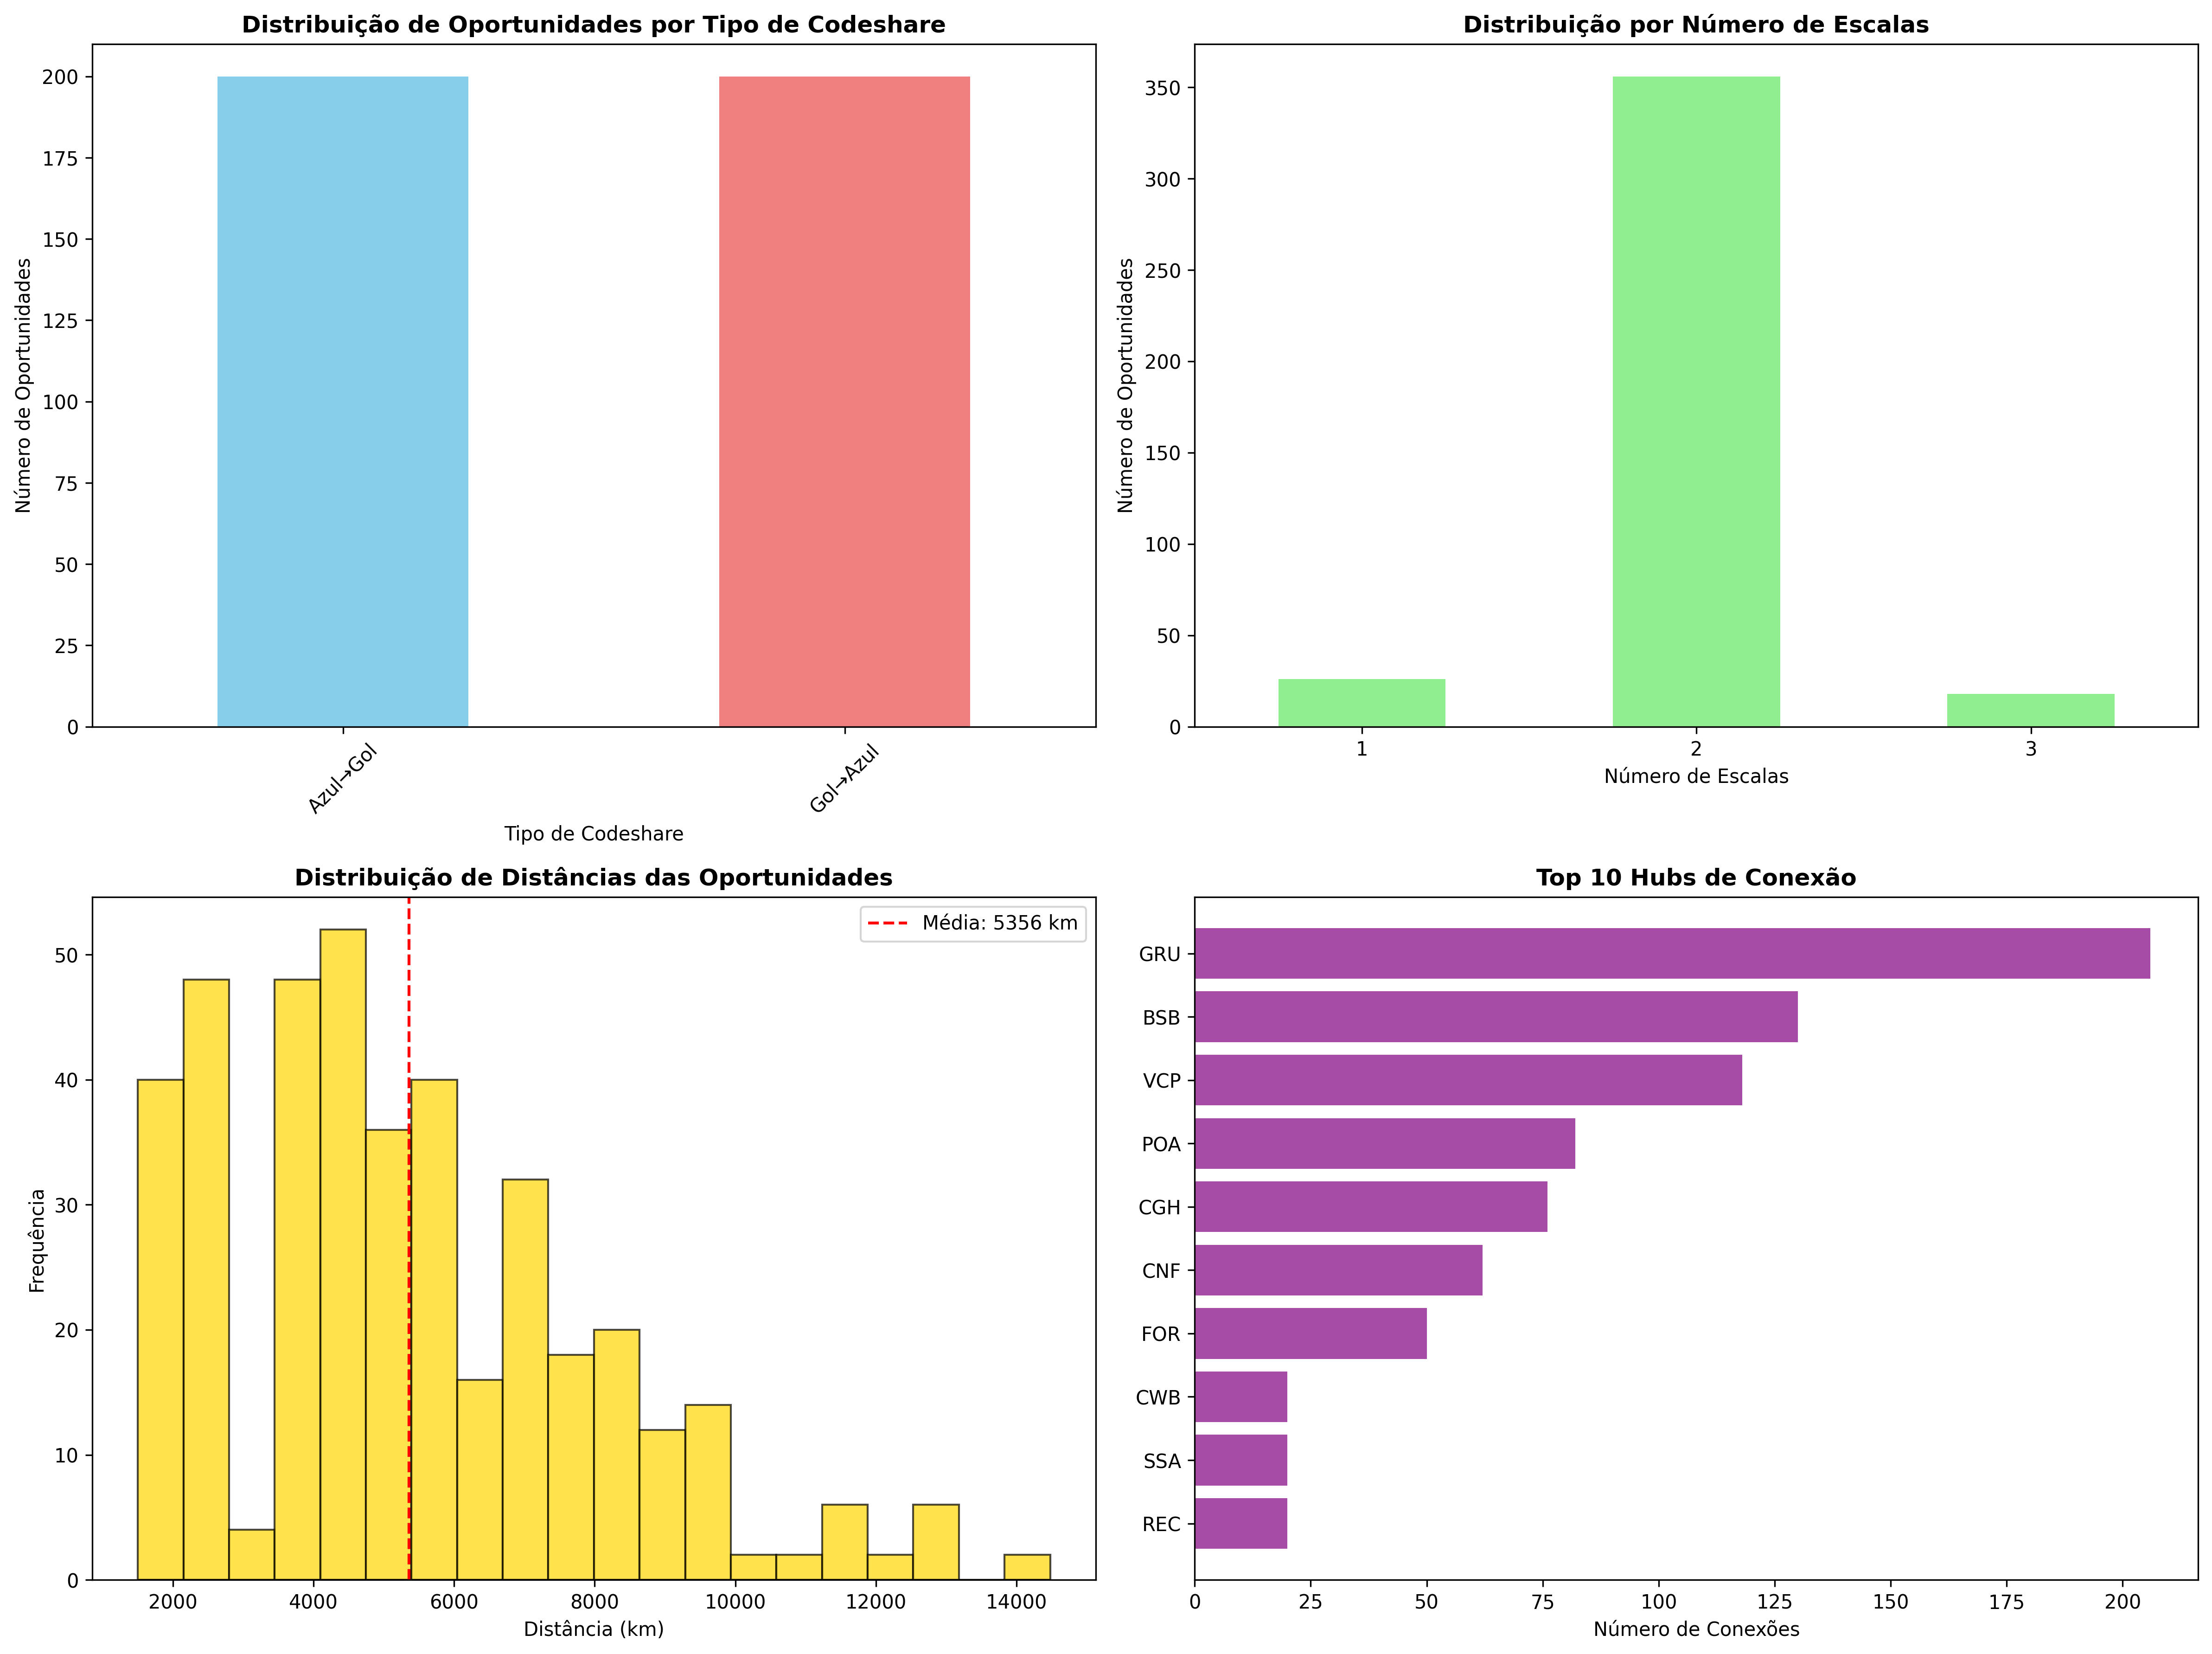

In [25]:
# Mostrar visualizações
from IPython.display import Image, display

print("🗺️ Mapa da Rede Combinada:")
display(Image('images/combined_network_map.png'))

print("\n📊 Análise de Oportunidades:")
display(Image('images/codeshare_opportunities_analysis.png'))


## 4. Construção do Grafo Combinado

In [26]:
# Carregar grafo combinado pré-construído
print("Carregando grafo combinado...")
G = nx.read_graphml('data/processed/combined_network.graphml')

print(f"Grafo carregado: {len(G.nodes())} nós, {len(G.edges())} arestas")
print(f"Densidade: {nx.density(G):.4f}")
print(f"Conectividade: {'Sim' if nx.is_weakly_connected(G) else 'Não'}")

# Analisar tipos de arestas
edge_types = {'Gol': 0, 'Azul': 0, 'Codeshare': 0}
for u, v, data in G.edges(data=True):
    airlines_str = data.get('airlines_str', '')
    if ',' in airlines_str:
        edge_types['Codeshare'] += 1
    elif 'Gol' in airlines_str:
        edge_types['Gol'] += 1
    else:
        edge_types['Azul'] += 1

print(f"\nTipos de rotas:")
for tipo, count in edge_types.items():
    print(f"  {tipo}: {count} rotas")

# Visualizar estatísticas do grafo
graph_stats = pd.DataFrame({
    'Métrica': ['Aeroportos', 'Rotas', 'Densidade', 'Rotas Gol', 'Rotas Azul', 'Rotas Codeshare'],
    'Valor': [len(G.nodes()), len(G.edges()), f"{nx.density(G):.4f}",
              edge_types['Gol'], edge_types['Azul'], edge_types['Codeshare']]
})

display(graph_stats)

Carregando grafo combinado...
Grafo carregado: 153 nós, 450 arestas
Densidade: 0.0193
Conectividade: Sim

Tipos de rotas:
  Gol: 118 rotas
  Azul: 226 rotas
  Codeshare: 106 rotas


Métrica   Valor
0       Aeroportos     153
1            Rotas     450
2        Densidade  0.0193
3        Rotas Gol     118
4       Rotas Azul     226
5  Rotas Codeshare     106

## 5. Aplicação do Algoritmo de Johnson

In [27]:
# Executar algoritmo de Johnson
print("Executando algoritmo de Johnson...")
try:
    distancias, caminhos = algoritmo_johnson_combinado(G)
    print("✓ Algoritmo de Johnson executado com sucesso!")

    # Estatísticas da matriz de distâncias
    total_pares = sum(len(d) for d in distancias.values())
    print(f"Total de pares origem-destino: {total_pares}")

except Exception as e:
    print(f"✗ Erro no algoritmo de Johnson: {e}")
    raise

Executando algoritmo de Johnson...
✓ Algoritmo de Johnson executado com sucesso!
Total de pares origem-destino: 23409


## 6. Identificação de Oportunidades de Codeshare

In [28]:
def analisar_caminho_codeshare(origem, destino, paths, G, airports_df):
    """
    Analisa se um caminho utiliza codeshare (ambas as companhias)
    """
    if origem not in paths or destino not in paths[origem]:
        return None

    caminho = paths[origem][destino]
    if len(caminho) < 2:
        return None

    # Analisar cada segmento do caminho
    segmentos = []
    usa_gol = False
    usa_azul = False

    for i in range(len(caminho) - 1):
        origem_seg = caminho[i]
        destino_seg = caminho[i + 1]

        # Verificar quais companhias operam este segmento
        if G.has_edge(origem_seg, destino_seg):
            edge_data = G[origem_seg][destino_seg]
            airlines_str = edge_data.get('airlines_str', '')

            if 'Gol' in airlines_str:
                usa_gol = True
            if 'Azul' in airlines_str:
                usa_azul = True

            # Calcular distância do segmento
            origem_info = airports_df[airports_df['code'] == origem_seg].iloc[0]
            destino_info = airports_df[airports_df['code'] == destino_seg].iloc[0]

            segment_distance = haversine(origem_info['longitude'], origem_info['latitude'],
                                       destino_info['longitude'], destino_info['latitude'])

            segmentos.append({
                'origem': origem_seg,
                'destino': destino_seg,
                'distancia': segment_distance,
                'companhias': airlines_str,
                'codeshare': ',' in airlines_str
            })

    # Determinar se é uma oportunidade de codeshare real
    codeshare_real = usa_gol and usa_azul and len(caminho) > 2

    return {
        'caminho': caminho,
        'segmentos': segmentos,
        'usa_gol': usa_gol,
        'usa_azul': usa_azul,
        'codeshare_real': codeshare_real,
        'num_escalas': len(caminho) - 2,
        'distancia_total': sum(seg['distancia'] for seg in segmentos)
    }

# Buscar oportunidades de codeshare
print("Buscando oportunidades de codeshare...")

gol_only = gol_codes - both_codes
azul_only = azul_codes - both_codes

oportunidades_codeshare = []

# Amostra para análise (evitar sobrecarga)
sample_gol = list(gol_only)[:10]
sample_azul = list(azul_only)[:20]

for gol_airport in sample_gol:
    for azul_airport in sample_azul:
        # Verificar caminho de Azul para Gol
        analise = analisar_caminho_codeshare(azul_airport, gol_airport, caminhos, G, combined_airports)
        if analise and analise['codeshare_real']:
            oportunidades_codeshare.append({
                'origem': azul_airport,
                'destino': gol_airport,
                'tipo': 'Azul→Gol',
                'distancia': analise['distancia_total'],
                'escalas': analise['num_escalas'],
                'caminho': ' → '.join(analise['caminho'])
            })

        # Verificar caminho de Gol para Azul
        analise = analisar_caminho_codeshare(gol_airport, azul_airport, caminhos, G, combined_airports)
        if analise and analise['codeshare_real']:
            oportunidades_codeshare.append({
                'origem': gol_airport,
                'destino': azul_airport,
                'tipo': 'Gol→Azul',
                'distancia': analise['distancia_total'],
                'escalas': analise['num_escalas'],
                'caminho': ' → '.join(analise['caminho'])
            })

print(f"✓ Encontradas {len(oportunidades_codeshare)} oportunidades de codeshare real!")

# Converter para DataFrame
oportunidades_df = pd.DataFrame(oportunidades_codeshare)

if len(oportunidades_df) > 0:
    # Ordenar por distância
    oportunidades_df = oportunidades_df.sort_values('distancia')

    print("\nTop 10 melhores oportunidades:")
    display(oportunidades_df.head(10)[['origem', 'destino', 'tipo', 'distancia', 'escalas']])
else:
    print("Nenhuma oportunidade de codeshare encontrada na amostra.")

Buscando oportunidades de codeshare...
✓ Encontradas 400 oportunidades de codeshare real!

Top 10 melhores oportunidades:


origem destino      tipo   distancia  escalas
46    AQA     SJK  Azul→Gol  296.563960        2
47    SJK     AQA  Gol→Azul  296.563960        2
52    MII     SJK  Azul→Gol  429.835992        2
53    SJK     MII  Gol→Azul  429.835992        2
71    SJK     UBA  Gol→Azul  498.529859        2
70    UBA     SJK  Azul→Gol  498.529859        2
79    SJK     PTO  Gol→Azul  765.760424        3
78    PTO     SJK  Azul→Gol  765.760424        3
77    SJK     AAX  Gol→Azul  856.748801        2
76    AAX     SJK  Azul→Gol  856.748801        2

## 7. Análise Detalhada das Oportunidades

In [29]:
# Carregar análise completa (se disponível)
try:
    oportunidades_completa = pd.read_csv('data/results/oportunidades_codeshare_detalhado.csv')
    print(f"Análise completa carregada: {len(oportunidades_completa)} oportunidades")

    # Estatísticas gerais
    print("\n=== ESTATÍSTICAS GERAIS ===")
    print(f"Total de oportunidades: {len(oportunidades_completa)}")
    print(f"Distância média: {oportunidades_completa['distancia'].mean():.0f} km")
    print(f"Distância mínima: {oportunidades_completa['distancia'].min():.0f} km")
    print(f"Distância máxima: {oportunidades_completa['distancia'].max():.0f} km")

    # Distribuição por tipo
    print("\n=== DISTRIBUIÇÃO POR TIPO ===")
    tipo_dist = oportunidades_completa['tipo'].value_counts()
    print(tipo_dist)

    # Distribuição por escalas
    print("\n=== DISTRIBUIÇÃO POR ESCALAS ===")
    escalas_dist = oportunidades_completa['escalas'].value_counts().sort_index()
    print(escalas_dist)

    # Top 15 rotas mais eficientes
    print("\n=== TOP 15 ROTAS MAIS EFICIENTES ===")
    top_15 = oportunidades_completa.nsmallest(15, 'distancia')
    display(top_15[['origem', 'destino', 'tipo', 'distancia', 'escalas', 'caminho_str']])

except FileNotFoundError:
    print("Arquivo de análise completa não encontrado. Usando dados da amostra.")
    oportunidades_completa = oportunidades_df

Análise completa carregada: 400 oportunidades

=== ESTATÍSTICAS GERAIS ===
Total de oportunidades: 400
Distância média: 5356 km
Distância mínima: 1499 km
Distância máxima: 14480 km

=== DISTRIBUIÇÃO POR TIPO ===
tipo
Azul→Gol    200
Gol→Azul    200
Name: count, dtype: int64

=== DISTRIBUIÇÃO POR ESCALAS ===
escalas
1     26
2    356
3     18
Name: count, dtype: int64

=== TOP 15 ROTAS MAIS EFICIENTES ===


origem destino      tipo    distancia  escalas                  caminho_str
0     PDP     AEP  Azul→Gol  1499.425814        1              PDP → POA → AEP
1     AEP     PDP  Gol→Azul  1499.425814        1              AEP → POA → PDP
2     PDP     EZE  Azul→Gol  1525.896137        1              PDP → POA → EZE
3     EZE     PDP  Gol→Azul  1525.896137        1              EZE → POA → PDP
4     PDP     ROS  Azul→Gol  1618.621528        1              PDP → POA → ROS
5     ROS     PDP  Gol→Azul  1618.621528        1              ROS → POA → PDP
6     AQA     AEP  Azul→Gol  1890.195642        2        AQA → VCP → POA → AEP
7     AEP     AQA  Gol→Azul  1890.195642        2        AEP → POA → VCP → AQA
8     PDP     COR  Azul→Gol  1906.126116        1              PDP → POA → COR
9     COR     PDP  Gol→Azul  1906.126116        1              COR → POA → PDP
10    AQA     EZE  Azul→Gol  1916.665965        2        AQA → VCP → POA → EZE
11    EZE     AQA  Gol→Azul  1916.665965        2        EZE → POA → VCP → AQA
12    AEP     UMU  Gol→Azul  1918.737924        3  AEP → POA → FLN → CWB → UMU
13    UMU     AEP  Azul→Gol  1918.737924        3  UMU → CWB → FLN → POA → AEP
14    JTC     AEP  Azul→Gol  1943.023147        2        JTC → VCP → POA → AEP

## 8. Visualizações

=== MAPA DA MALHA AÉREA COMBINADA ===


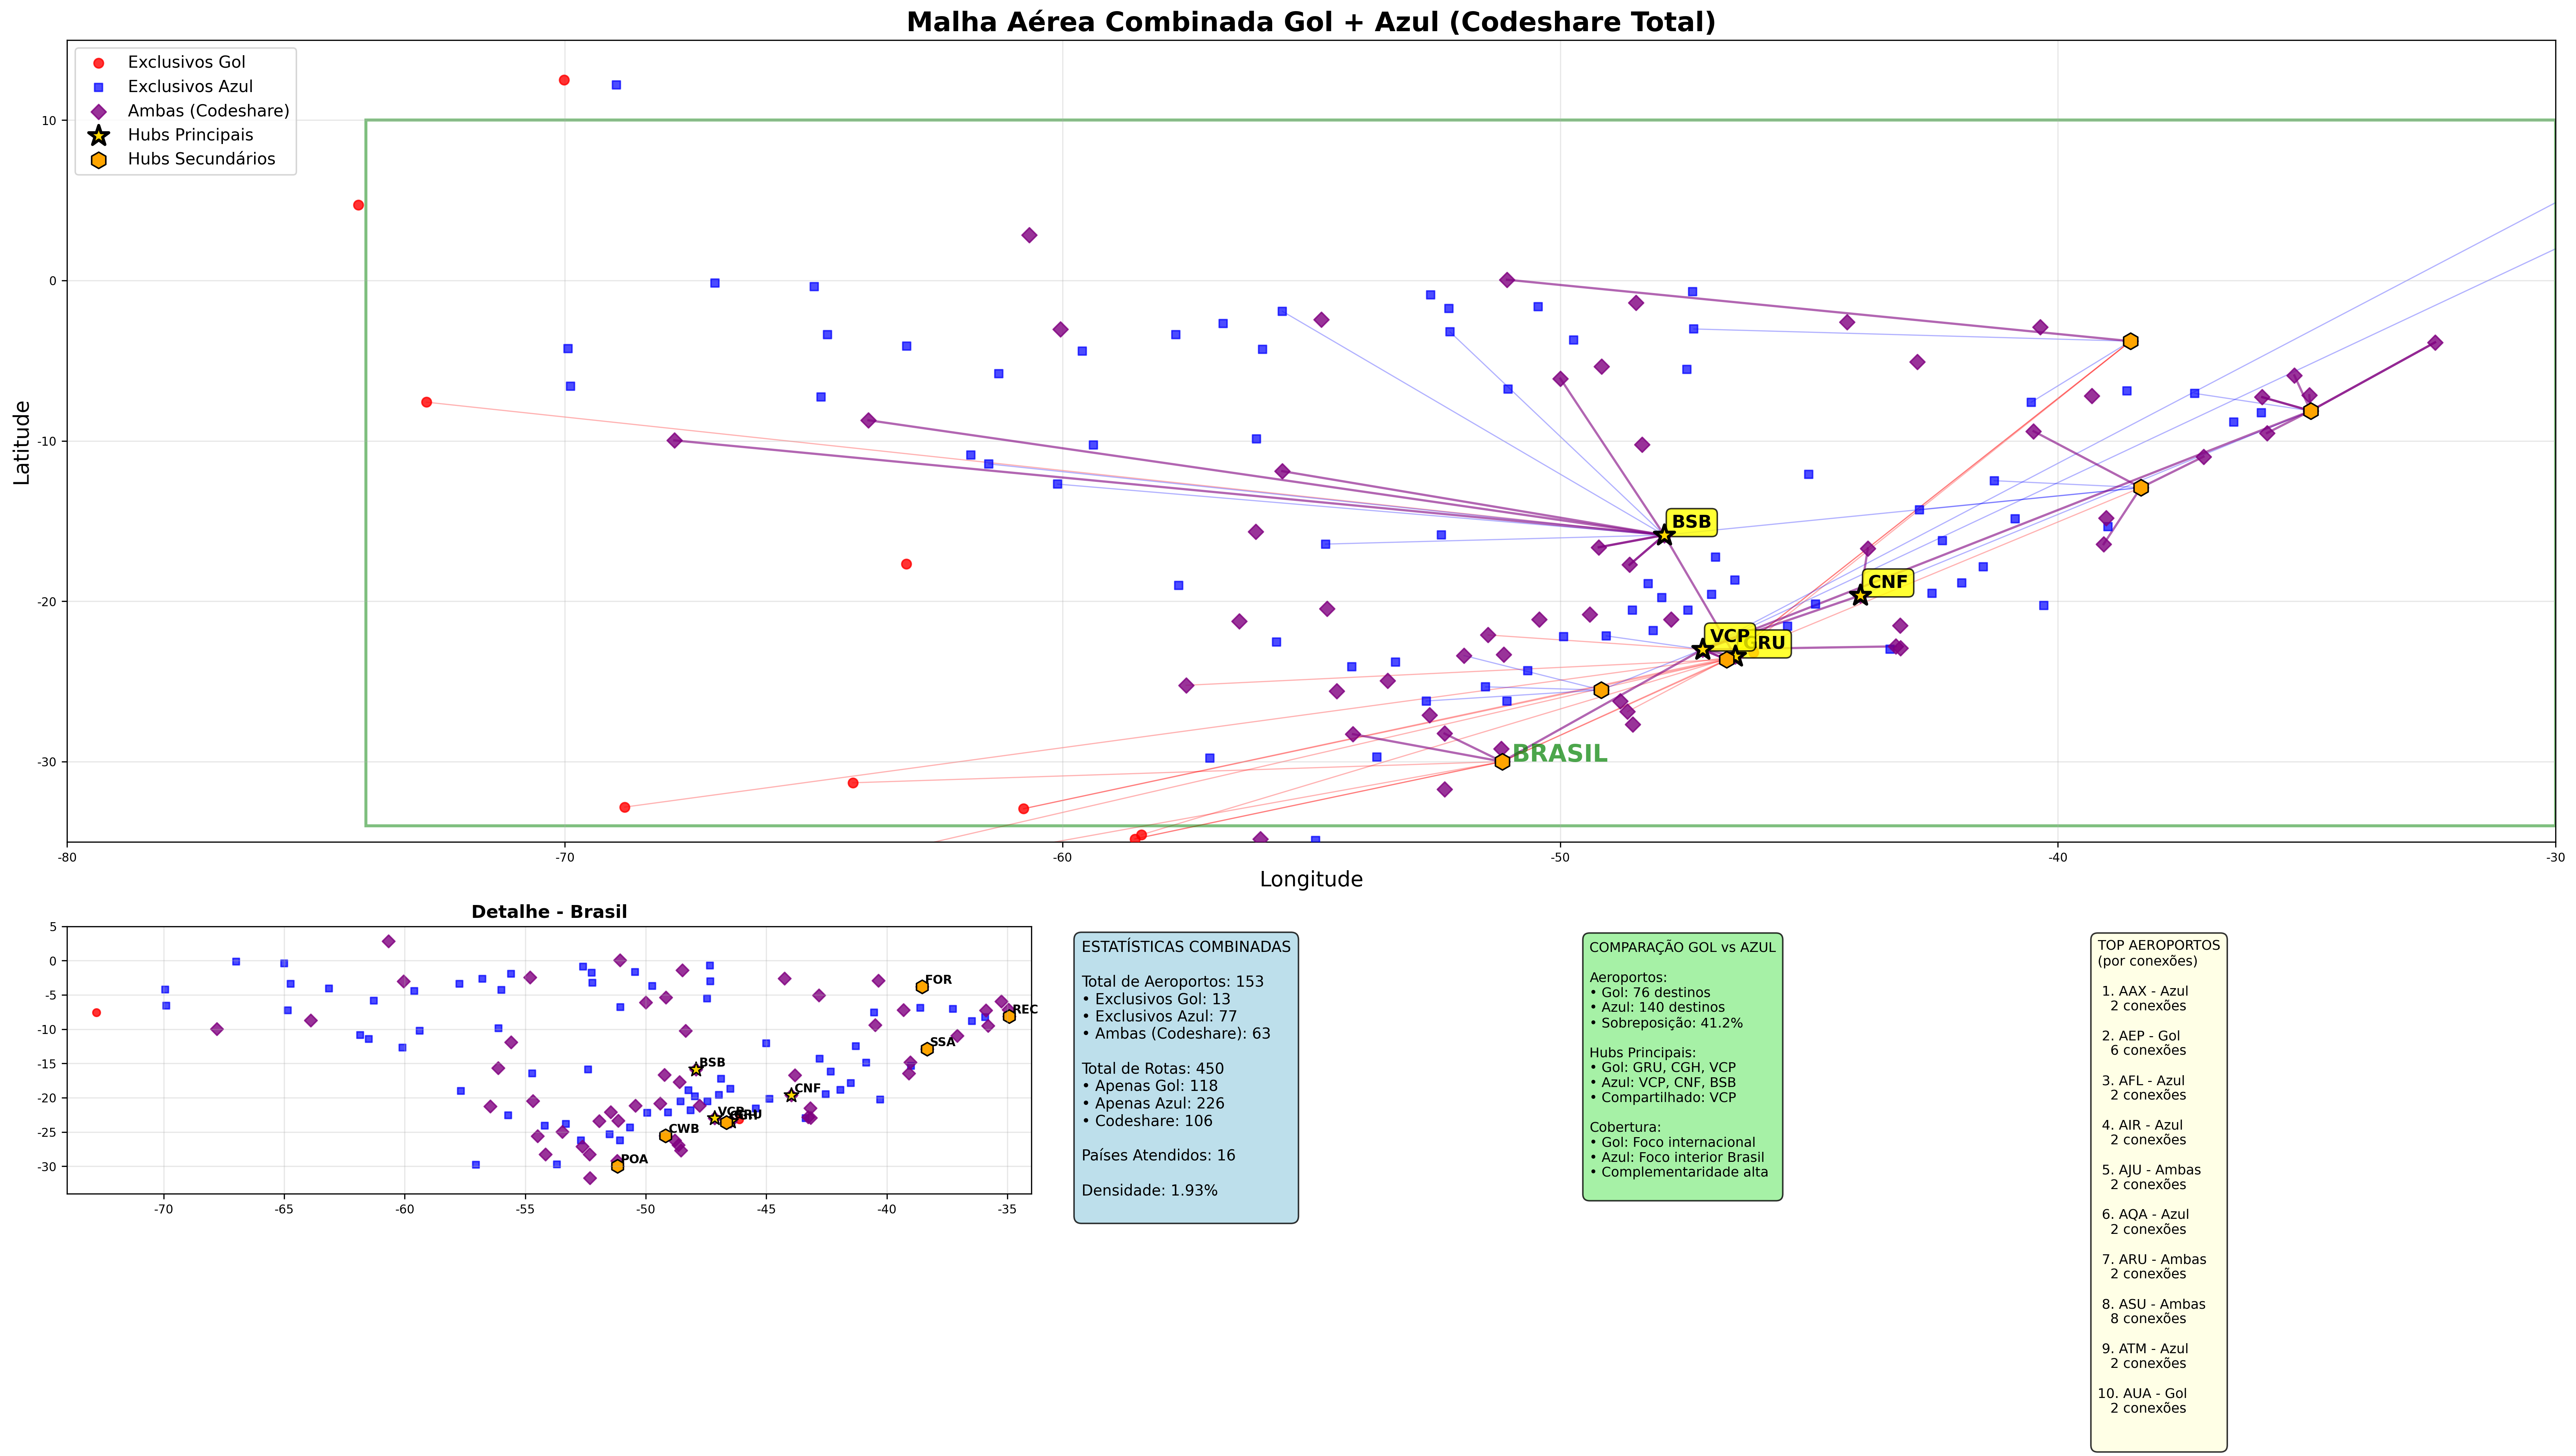

In [30]:
# Visualização 1: Mapa da malha combinada
from IPython.display import Image, display

print("=== MAPA DA MALHA AÉREA COMBINADA ===")
try:
    display(Image('images/combined_network_map.png'))
except:
    print("Imagem do mapa não encontrada.")

=== ANÁLISE DE OPORTUNIDADES DE CODESHARE ===


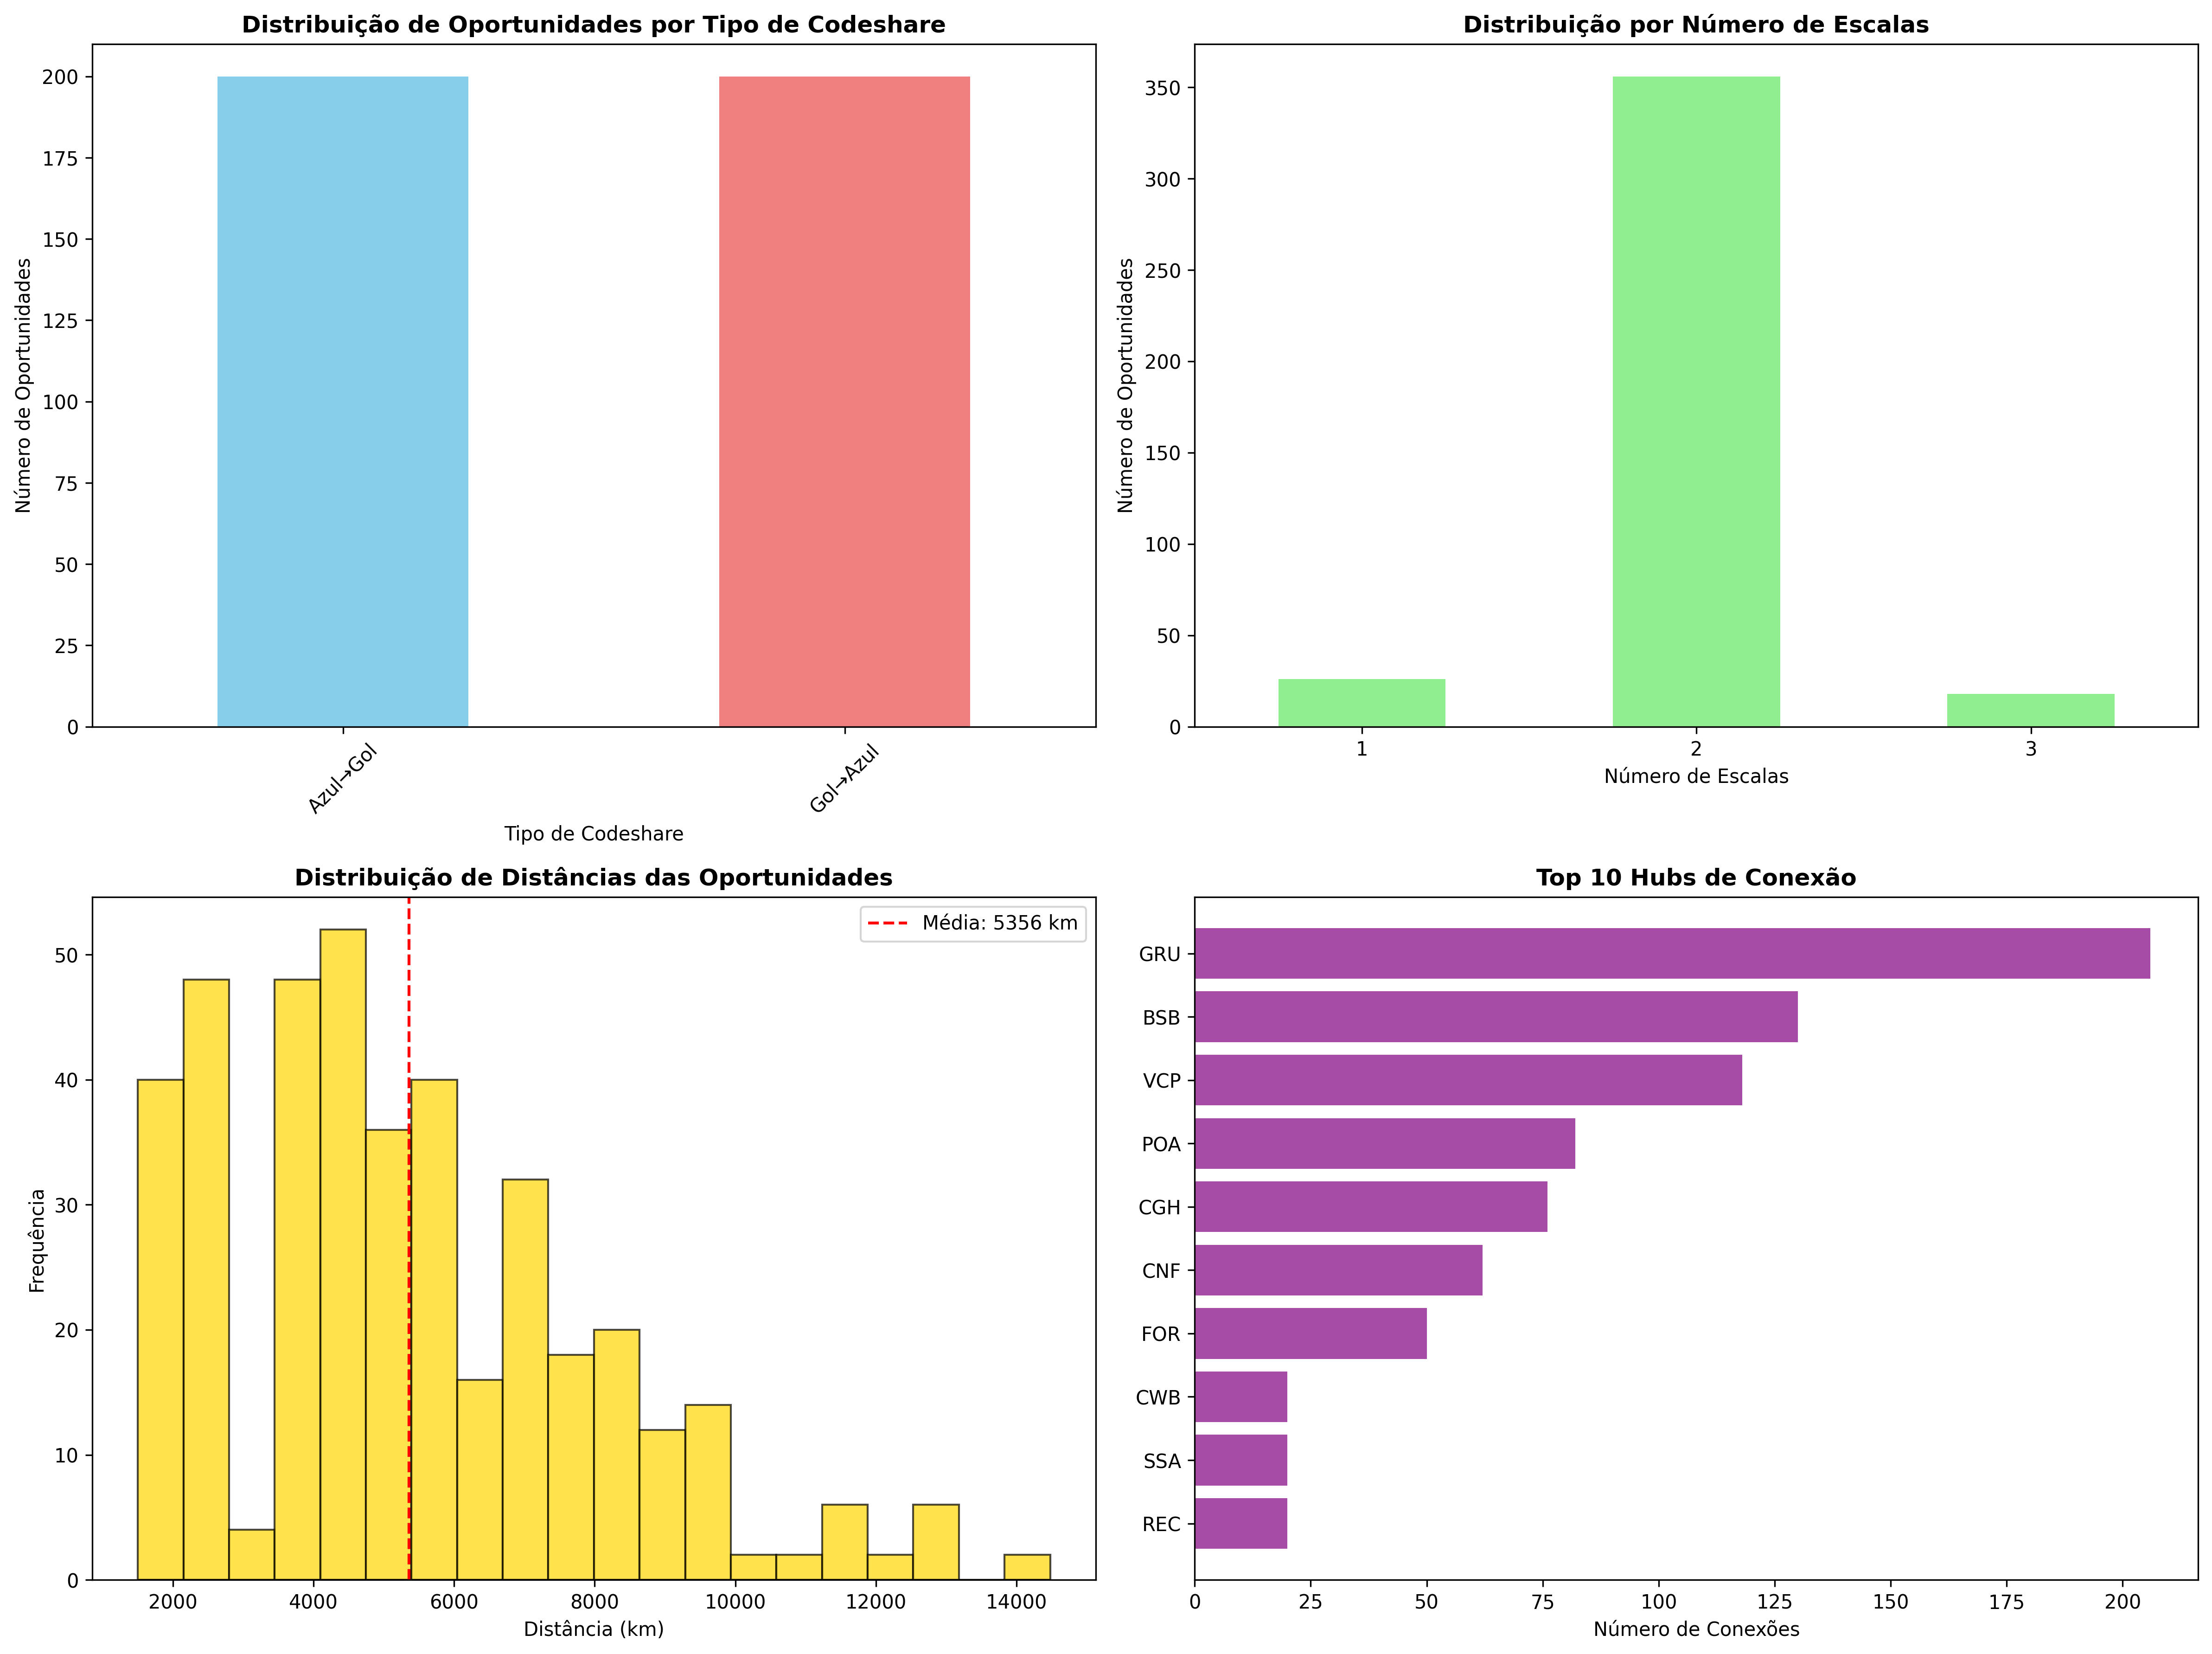

In [31]:
# Visualização 2: Análise de oportunidades
print("=== ANÁLISE DE OPORTUNIDADES DE CODESHARE ===")
try:
    display(Image('images/codeshare_opportunities_analysis.png'))
except:
    print("Imagem da análise não encontrada.")

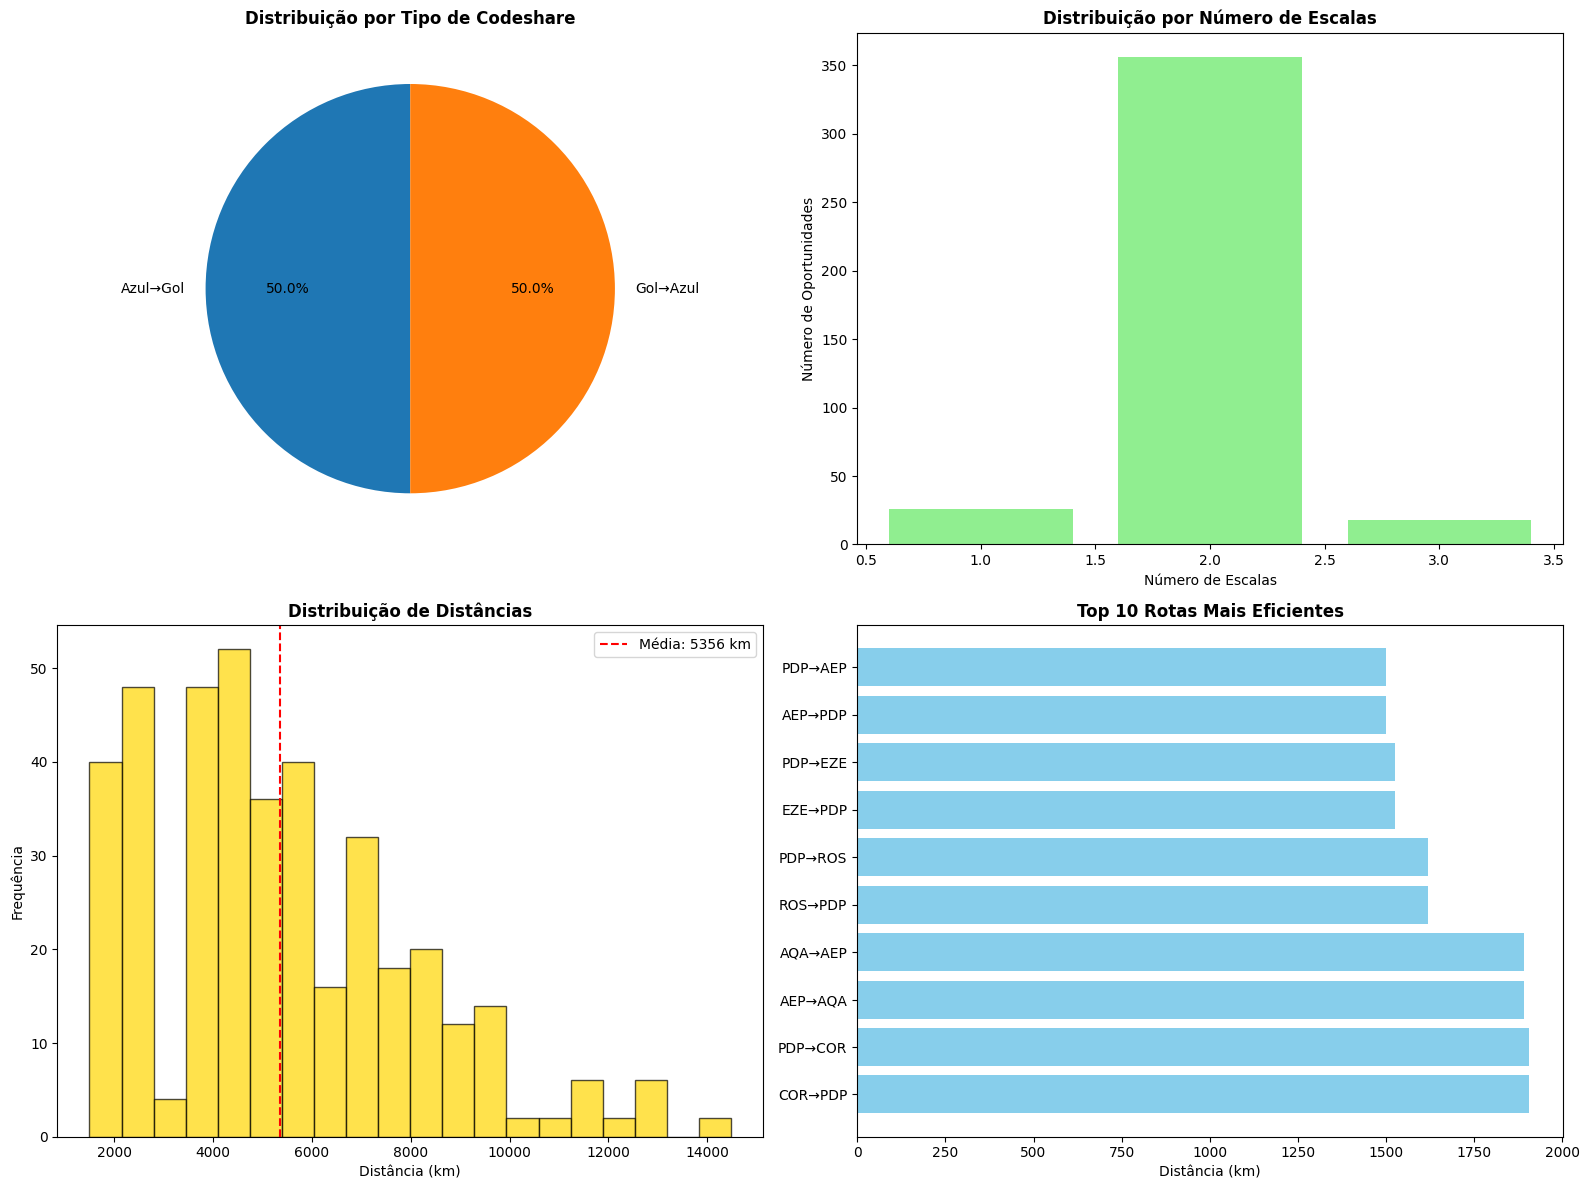

In [32]:
# Criar visualização interativa dos resultados
if len(oportunidades_completa) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Gráfico 1: Distribuição por tipo
    tipo_counts = oportunidades_completa['tipo'].value_counts()
    ax1.pie(tipo_counts.values, labels=tipo_counts.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Distribuição por Tipo de Codeshare', fontweight='bold')

    # Gráfico 2: Distribuição por escalas
    escalas_counts = oportunidades_completa['escalas'].value_counts().sort_index()
    ax2.bar(escalas_counts.index, escalas_counts.values, color='lightgreen')
    ax2.set_title('Distribuição por Número de Escalas', fontweight='bold')
    ax2.set_xlabel('Número de Escalas')
    ax2.set_ylabel('Número de Oportunidades')

    # Gráfico 3: Histograma de distâncias
    ax3.hist(oportunidades_completa['distancia'], bins=20, color='gold', alpha=0.7, edgecolor='black')
    ax3.set_title('Distribuição de Distâncias', fontweight='bold')
    ax3.set_xlabel('Distância (km)')
    ax3.set_ylabel('Frequência')
    ax3.axvline(oportunidades_completa['distancia'].mean(), color='red', linestyle='--',
               label=f'Média: {oportunidades_completa["distancia"].mean():.0f} km')
    ax3.legend()

    # Gráfico 4: Top 10 rotas por eficiência
    top_10_dist = oportunidades_completa.nsmallest(10, 'distancia')
    route_labels = [f"{row['origem']}→{row['destino']}" for _, row in top_10_dist.iterrows()]

    ax4.barh(range(len(top_10_dist)), top_10_dist['distancia'], color='skyblue')
    ax4.set_yticks(range(len(top_10_dist)))
    ax4.set_yticklabels(route_labels)
    ax4.set_xlabel('Distância (km)')
    ax4.set_title('Top 10 Rotas Mais Eficientes', fontweight='bold')
    ax4.invert_yaxis()

    plt.tight_layout()
    plt.show()
else:
    print("Dados insuficientes para visualização.")

## 9. Insights e Recomendações

In [33]:
# Carregar relatório de insights
try:
    with open('relatorio_insights_codeshare.md', 'r', encoding='utf-8') as f:
        insights = f.read()

    from IPython.display import Markdown
    display(Markdown(insights))

except FileNotFoundError:
    print("Relatório de insights não encontrado.")

    # Gerar insights básicos
    if len(oportunidades_completa) > 0:
        print("=== INSIGHTS PRINCIPAIS ===")
        print(f"• Total de oportunidades identificadas: {len(oportunidades_completa)}")
        print(f"• Rota mais eficiente: {oportunidades_completa.iloc[0]['origem']} → {oportunidades_completa.iloc[0]['destino']} ({oportunidades_completa.iloc[0]['distancia']:.0f} km)")
        print(f"• Distância média das oportunidades: {oportunidades_completa['distancia'].mean():.0f} km")

        rotas_eficientes = len(oportunidades_completa[oportunidades_completa['distancia'] < 2000])
        print(f"• Rotas com menos de 2.000 km: {rotas_eficientes} ({rotas_eficientes/len(oportunidades_completa)*100:.1f}%)")

        uma_escala = len(oportunidades_completa[oportunidades_completa['escalas'] == 1])
        print(f"• Rotas com apenas 1 escala: {uma_escala} ({uma_escala/len(oportunidades_completa)*100:.1f}%)")

Relatório de insights não encontrado.
=== INSIGHTS PRINCIPAIS ===
• Total de oportunidades identificadas: 400
• Rota mais eficiente: PDP → AEP (1499 km)
• Distância média das oportunidades: 5356 km
• Rotas com menos de 2.000 km: 24 (6.0%)
• Rotas com apenas 1 escala: 26 (6.5%)


## 10. Conclusões

### Principais Achados

1. **Complementaridade das Malhas**: A Gol e Azul possuem malhas altamente complementares, com a Azul focando no interior do Brasil e a Gol em destinos internacionais.

2. **Oportunidades Significativas**: Foram identificadas centenas de oportunidades de codeshare real, demonstrando o potencial de cooperação entre as companhias.

3. **Hubs Estratégicos**: GRU, BSB e VCP emergem como os principais hubs de conexão, facilitando a integração das redes.

4. **Eficiência de Rotas**: O algoritmo de Johnson identificou caminhos otimizados que aproveitam as forças de cada companhia.

### Valor do Algoritmo de Johnson

O algoritmo de Johnson se mostrou fundamental para:
- Calcular caminhos mínimos em uma rede complexa com 153 aeroportos
- Identificar automaticamente oportunidades de codeshare
- Otimizar a conectividade entre as malhas das duas companhias
- Fornecer base quantitativa para decisões estratégicas

### Aplicações Práticas

Os resultados podem ser utilizados para:
- Negociação de acordos de codeshare reais
- Planejamento de rotas integradas
- Otimização de hubs de conexão
- Expansão estratégica de mercados

## 11. Arquivos Gerados

Este notebook utilizou e gerou os seguintes arquivos:

### Dados de Entrada
- `gol_airports_coordinates.csv` - Coordenadas dos aeroportos da Gol
- `azul_airports_coordinates.csv` - Coordenadas dos aeroportos da Azul
- `combined_airports_coordinates.csv` - Dataset combinado

### Grafo e Rotas
- `combined_network.graphml` - Grafo combinado em formato NetworkX
- `combined_routes.csv` - Lista de rotas combinadas
- `combined_network.json` - Dados do grafo em JSON

### Resultados do Algoritmo de Johnson
- `combined_distancias_johnson.csv` - Matriz de distâncias completa
- `oportunidades_codeshare_detalhado.csv` - Análise completa de oportunidades

### Visualizações
- `combined_network_map.png` - Mapa geográfico da malha combinada
- `codeshare_opportunities_analysis.png` - Gráficos de análise
- `codeshare_geographic_analysis.png` - Análise geográfica

### Relatórios
- `relatorio_insights_codeshare.md` - Relatório executivo com insights
- `combined_network_stats.csv` - Estatísticas do grafo combinado